In [16]:
# !pip install scikit-learn
# !pip install keras
# !pip install pydot
# !pip install matplotlib
# !pip install tensorflow


# Stock price prediction using our Keras’ LSTMs model trained on past stocks data.

## Step 1 - Import the Libraries

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

## Step 2 – Reading our training data and getting our training data in shape

In [18]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    # data.reset_index(inplace=True)
    return data

def feature_engineering(data):
    # Calculate MACD
    data['macd'] = ta.trend.macd(data['Adj Close'])
    
    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Adj Close'])
    data['boll_ub'] = bollinger.bollinger_hband()
    data['boll_lb'] = bollinger.bollinger_lband()
    
    # Calculate RSI with a window size of 30
    rsi_window = 30
    data[f'rsi_{rsi_window}'] = ta.momentum.RSIIndicator(data['Adj Close'], window=rsi_window).rsi()
    
    # Calculate ADX with a window size of 30
    adx_window = 30
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Adj Close'], window=adx_window)
    data[f'dx_{adx_window}'] = adx.adx()
    
    # Calculate SMA
    data['close_30_sma'] = data['Adj Close'].rolling(window=30).mean()
    data['close_60_sma'] = data['Adj Close'].rolling(window=60).mean()
    
    # Drop rows with NaN values after feature creation
    data.dropna(inplace=True)
    
    return data
    return data

# Define the stock ticker and the training time frame
stock_ticker = "MSFT"
start_date = "2010-01-01"  # Start with a long enough historical period
end_date = "2024-01-01"   

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)    
dataset_train['returns'] = dataset_train['Adj Close'].pct_change().fillna(0)
dataset_train['direction'] = np.where(dataset_train['Adj Close'].shift(-1) > dataset_train['Adj Close'], 1, 0)

#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", dataset_train.shape)
print("Null Value Present: ", dataset_train.isnull().values.any())

[*********************100%%**********************]  1 of 1 completed

Dataframe Shape:  (3463, 15)
Null Value Present:  False


## Step 3 - Setting the Target Variable, Selecting the Features, and Scaling

In [19]:
## Step 3 - Setting the Target Variable, Selecting the Features, and Scaling
output_var = pd.DataFrame(dataset_train['Adj Close'])
features = ['Adj Close', 'Volume', 'boll_ub', 'boll_lb', 'rsi_30', 'close_30_sma', 'close_60_sma']

scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset_train[features])
output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

# Convert back to DataFrame
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)


## Step 4 - Splitting to Training set and Test set

In [20]:
train_size = int(len(feature_transform) * 0.8)
X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

## Step 5 - Building and Training the LSTM Model

In [21]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100


c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.1858e-05
Epoch 2/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038
Epoch 3/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 6.1670e-04
Epoch 4/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5360e-05
Epoch 5/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9800e-05  
Epoch 6/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4470e-05
Epoch 7/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 2.5346e-05
Epoch 8/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8985e-05
Epoch 9/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8606e-05
Epoch 10/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4228e-05
Epoch 11/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 4.1142e-05
Epoch 12/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2031e-05
Epoch 13/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 3.0044e-05
Epoch 14/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 1.

## Step 6 - Making the Prediction

In [22]:
y_pred = lstm.predict(X_test)

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])
        
        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

days_to_predict = 10
last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_predictions = future_predictions.flatten()
future_predictions

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

C:\Users\leand\AppData\Local\Temp\ipykernel_22264\2172239166.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([388.8489 , 394.41208, 396.60617, 397.4732 , 397.81616, 397.95184,
       398.00552, 398.0268 , 398.03525, 398.03854], dtype=float32)

## Step 7- Evaluate Model

In [23]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE on Test Set: {mse:.4f}')
print(f'R2 Score on Test Set: {r2:.4f}')

MSE on Test Set: 0.0002
R2 Score on Test Set: 0.9808


## Step 8 - Plot Predicted vs True Adj Close Value – LSTM


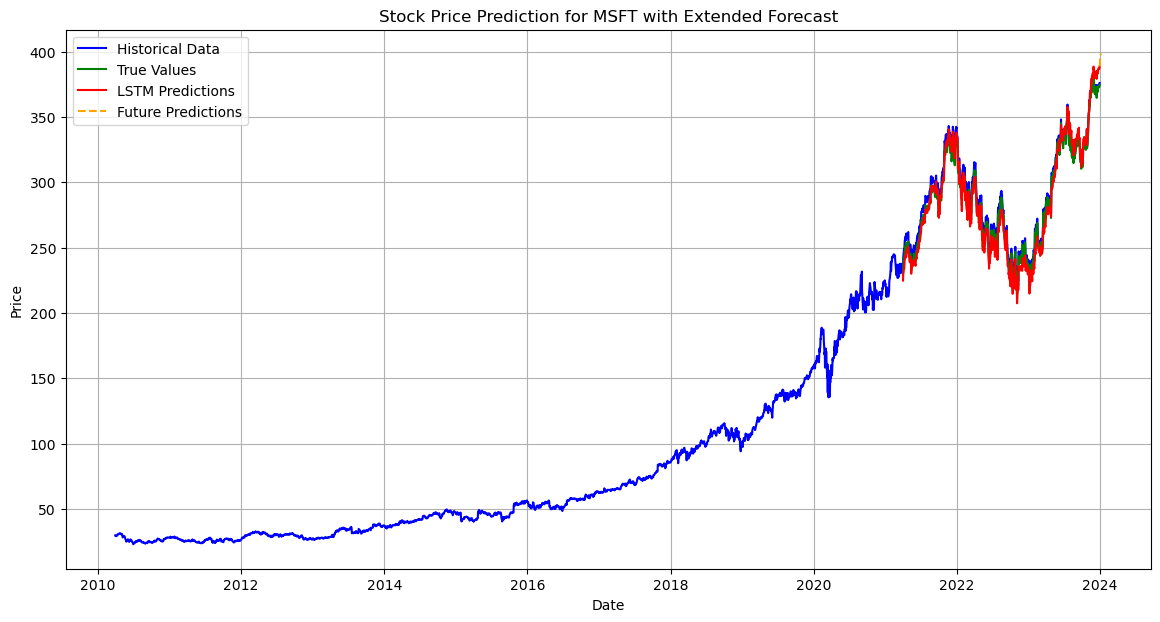

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare dates for plotting
last_date = dataset_train.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

# Prepare historical dates for plotting
historical_dates = dataset_train.index
test_dates = historical_dates[-len(y_test):]
predicted_dates = historical_dates[-len(y_pred):]

# Plot historical and predicted data
plt.figure(figsize=(14, 7))
plt.plot(historical_dates, dataset_train['Close'], label='Historical Data', color='blue')
plt.plot(test_dates, scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='green')
plt.plot(predicted_dates, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='LSTM Predictions', color='red')
plt.plot(future_dates, future_predictions, linestyle='--', color='orange', label='Future Predictions')

# Add labels and legend
plt.title(f'Stock Price Prediction for {stock_ticker} with Extended Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


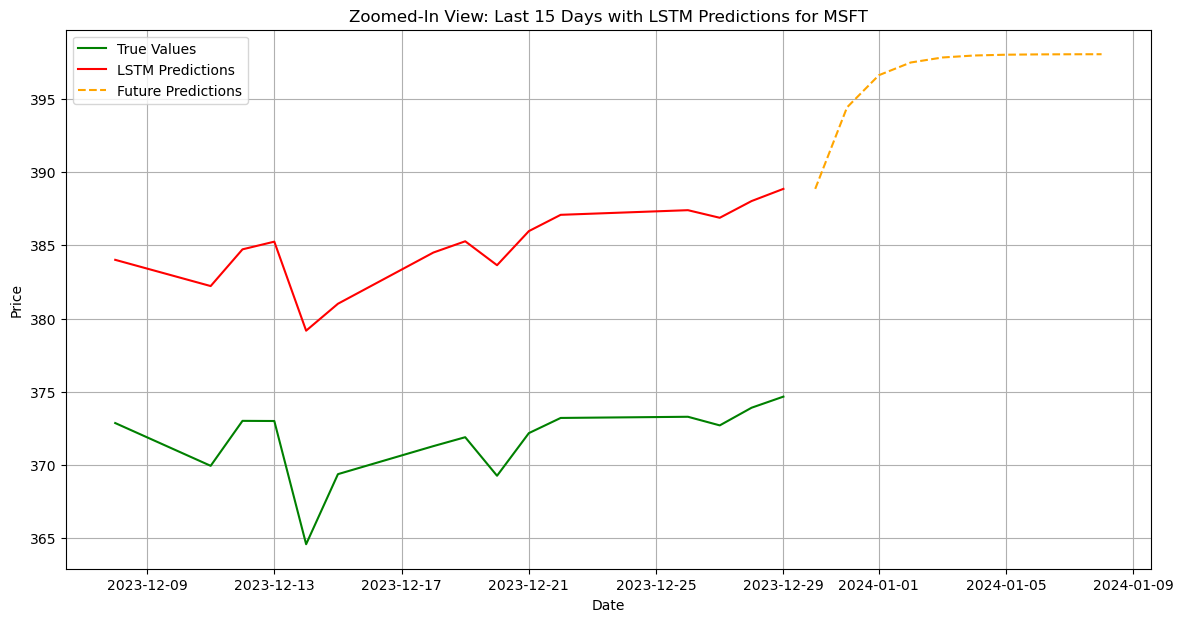

In [25]:
# Zoomed-In Plot for the Last 15 Days
plt.figure(figsize=(14, 7))

# Extracting the last 15 days data
zoom_start_date = dataset_train.index[-15]
zoom_end_date = dataset_train.index[-1]
zoom_dates = dataset_train.index[-15:]
zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days

plt.plot(zoom_dates, scaler.inverse_transform(output_var_scaled.loc[zoom_dates].values), label='True Values', color='green')
plt.plot(zoom_dates, zoom_lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(future_dates[:15], zoom_future_predictions, linestyle='--', color='orange', label='Future Predictions')

# Add labels and legend
plt.title(f'Zoomed-In View: Last 15 Days with LSTM Predictions for {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Backtesting on the model performance

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-31": #change this date for different period to test
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Record the 'Close' value, last_lstm_prediction, and average_future_predictions
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions]
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates and predictions
print(end_dates_df)

Rating performance by buying/selling every business day based on the 3 day prediction

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

def calculate_slope(prices, window=5):
    if len(prices) < window:
        return np.nan  # Not enough data to calculate slope
    
    x = np.arange(window)
    y = prices[-window:]
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions", "Slope"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-31":
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Calculate the slope of the last 5 days of closing prices
    slope = calculate_slope(dataset_train['Close'].values[-5:])

    # Record the 'Close' value, last_lstm_prediction, average_future_predictions, and slope
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions],
        "Slope": [slope]  # Store the calculated slope
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates, predictions, and slopes
print(end_dates_df)

10 day prediction backtest with stop-loss

In [ ]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

def calculate_slope(prices, window=5):
    if len(prices) < window:
        return np.nan  # Not enough data to calculate slope
    
    x = np.arange(window)
    y = prices[-window:]
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions", "Slope"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-10":
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Calculate the slope of the last 5 days of closing prices
    slope = calculate_slope(dataset_train['Close'].values[-5:])

    # Record the 'Close' value, last_lstm_prediction, average_future_predictions, and slope
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions],
        "Slope": [slope]  # Store the calculated slope
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates, predictions, and slopes
print(end_dates_df)


30 day prediction backtest with stop-loss

In [ ]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

def calculate_slope(prices, window=5):
    if len(prices) < window:
        return np.nan  # Not enough data to calculate slope
    
    x = np.arange(window)
    y = prices[-window:]
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions", "Slope"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-31":
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Calculate the slope of the last 5 days of closing prices
    slope = calculate_slope(dataset_train['Close'].values[-5:])

    # Record the 'Close' value, last_lstm_prediction, average_future_predictions, and slope
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions],
        "Slope": [slope]  # Store the calculated slope
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates, predictions, and slopes
print(end_dates_df)

In [ ]:
Evaluating stop-loss backtest model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(end_dates_df['Close'], end_dates_df['Last LSTM Prediction'])
rmse = mean_squared_error(end_dates_df['Close'], end_dates_df['Last LSTM Prediction'], squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")